In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import itertools


In [2]:
def get_list_cities_names():
    cities =['adelaide', 'antofagasta', 'athens', 'belfast', 'berlin', 'bordeaux', 'brisbane', 'canberra',
              'detroit', 'dublin', 'grenoble', 'helsinki', 'kuopio', 'lisbon', 'luxembourg', 'melbourne',
              'nantes', 'palermo', 'paris', 'prague', 'rennes', 'rome', 'sydney', 'toulouse', 'turku',
              'venice', 'winnipeg']
    return cities

In [4]:
def get_edges_cspace(path):
    '''
    Calculate edges from network_temporal_day.csv
    (Each route is represented by a node; each link corresponds to a common stop shared by the route.)
    '''
    data = pd.read_csv(path, delimiter=";")
    data_df = pd.DataFrame(data, columns=['from_stop_I', 'to_stop_I', 'dep_time_ut','arr_time_ut',
                                                 'route_type','trip_I','seq','route_I'])
    paths = {}
    path_number = 0
    paths[path_number] = [data_df.from_stop_I[path_number], data_df.to_stop_I[path_number]]
    for i in range(1,data_df.shape[0]):
        if (data_df.from_stop_I[i] == data_df.to_stop_I[i-1] and
            data_df.dep_time_ut[i] == data_df.arr_time_ut[i-1] and
            data_df.seq[i] == data_df.seq[i-1] + 1): 

                paths[path_number].append(data_df.to_stop_I[i])

        else:
            path_number += 1 
            temp = [data_df.from_stop_I[i], data_df.to_stop_I[i]]
            paths[path_number]=temp
    unique_paths = {}
    for k,v in paths.items():
        if v not in unique_paths.values():
            unique_paths[k]= v    
    paths = unique_paths
    edges = []
    for ktuple in itertools.combinations(paths,2):
            if [value for value in paths[ktuple[0]] if value in paths[ktuple[1]]] != []:
                edges.append(ktuple)
    return edges

In [5]:
def get_component_size_dist(net):
    
    dist = {}
    sizes = []
    for comp in sorted((net.subgraph(c) for c in nx.connected_components(net)), key = len):
        sizes.append(len(comp))
    for size in sizes:
        if size in dist:
            continue
        else:
            dist[size] = sizes.count(size)
    
    return dist

In [7]:
def compute_measures(net, city):
    GCC = max((net.subgraph(c) for c in nx.connected_components(net)), key=len)
    print( 'Number of nodes: ',  nx.number_of_nodes(net))
    print('Number of edges: ', nx.number_of_edges(net))
    print('Density: ',nx.density(net))
    print('Network diameter: ', nx.diameter(GCC))
    print('Average shortest path length: ', nx.average_shortest_path_length(GCC))
    print('Average clustering coefficient',  nx.average_clustering(net, count_zeros=True))
    print('Average degree: ', 2*net.number_of_edges() / float(net.number_of_nodes()))
    print('Number of component in the networek: ', len(list(net.subgraph(c) for c in nx.connected_components(net))))
    print( 'Assortativity: ', nx.degree_assortativity_coefficient(net))
    print( 'Component distribution', get_component_size_dist(net))
    print('Average degree conectivity: ', nx.average_degree_connectivity(net))


In [8]:
def ccdf(input_list):
    input_array = np.array(input_list)
    x_points = np.unique(input_array) 
    cdf = []
    normalizer=float(input_array.size) 

    for x in x_points:
        cdf.append((input_array[np.where(input_array >= x)].size)/normalizer)   

    return (x_points, np.array(cdf))

In [9]:
def plot_ccdfs(x,datavecs, markers, labels):
    fig = plt.figure(figsize=(15,10)) 
    ax = fig.add_subplot(111)
    for x_values, y_values, marker, label  in zip(x,datavecs, markers, labels):    
        ax.loglog(x_values, y_values, marker, label = label) 

    ax.set_xlabel('Degree' ) 
    ax.set_ylabel('1-CDF degree') 
    ax.legend(loc=0)
    ax.set_title('Degree distribution in C_space')
    plt.savefig("Degree_distribution_C_space.pdf", dpi=150)
    plt.show()
    


    return fig

In [17]:
def plot_degree_clustering(degrees,clusteringvec,markers, labels):
   
    fig = plt.figure(figsize=(15,10)) 
    ax = fig.add_subplot(111)
    for degree,clustering, marker, label  in zip(degrees,clusteringvec, markers, labels):  
        df = pd.DataFrame({"degree":degree,"clustering":clustering})
        df = df.sort_values(["degree"])
        mean_cluster = df.groupby("degree").mean()
        bins = np.array(mean_cluster.index.tolist())
        ax.plot(bins,mean_cluster,marker, label = label)
    ax.set_xlabel('Nodes Degree (ki)') 
    ax.set_ylabel('Clustering Coefficient (ci)') 
    ax.legend(loc=0)
    ax.set_title('Clustering coefficient in C_space')
    plt.savefig("Clustering_coefficient_C_space.pdf", dpi=150)
    plt.show()

    return fig

In [11]:
def get_centrality_measures(network):
    tol = 10**-1
    nodes = network.nodes()
    degrees = nx.degree_centrality(network)
    betweenness = nx.betweenness_centrality(network, normalized=True)
    closeness = nx.closeness_centrality(network)
    eigenvector_centrality = nx.eigenvector_centrality(network, tol = tol) 
   
    degree = np.array([v for k, v in  sorted(degrees.items(), key=lambda pair: list(nodes).index(pair[0]))])
    betweenness =np.array([v for k, v in  sorted(betweenness.items(), key=lambda  item: item[1], reverse = True)])
    closeness = np.array([v for k, v in  sorted(closeness.items(), key=lambda  item: item[1], reverse = True)])
    eigenvector_centrality = np.array([v for k, v in  sorted(eigenvector_centrality.items(),
                                                             key=lambda  item: item[1], reverse = True)])
    
    
    return [degree, betweenness, closeness, eigenvector_centrality]

In [12]:
cities = get_list_cities_names()
cities_ccdf_degree = {}
cities_degree = {}
cities_clustering = {}
cities_total_degree = {}
for i , city in enumerate(cities):
    print(30*'-', city, 30*'-')
    net = nx.Graph()
    
    path_edges = './data/'+city+'/network_temporal_day.csv'
    edges = get_edges_cspace(path_edges)
    net.add_edges_from(edges)
    
    compute_measures(net, city)
    degrees = [net.degree(node) for node in nx.nodes(net)]
    cities_degree[i],cities_ccdf_degree[i]=ccdf(degrees)
    clustering = list(nx.clustering(net).values())
    cities_clustering[i]= clustering
    cities_total_degree[i]= degrees
    

------------------------------ adelaide ------------------------------
Number of nodes:  1221
Number of edges:  56985
Density:  0.07650944536190438
Network diameter:  5
Average shortest path length:  2.347125940912201
Average clustering coefficient 0.5819840755216339
Average degree:  93.34152334152334
Number of component in the networek:  4
Assortativity:  0.39300607774967034
Component distribution {2: 1, 9: 1, 50: 1, 1160: 1}
Average degree conectivity:  {52: 88.99358974358974, 80: 97.0328125, 41: 98.05986696230599, 40: 105.7175, 24: 95.0324074074074, 58: 114.1949602122016, 56: 99.76470588235294, 103: 117.8876560332871, 31: 101.41666666666667, 115: 139.231884057971, 183: 163.87795992714027, 191: 154.2408376963351, 176: 162.85795454545453, 145: 138.50775862068966, 124: 135.77620967741936, 97: 124.72551546391753, 155: 154.89354838709679, 117: 120.52991452991454, 128: 124.38541666666667, 221: 135.60407239819006, 67: 98.04601990049751, 112: 109.04761904761905, 177: 153.7949959644875, 203:

Network diameter:  5
Average shortest path length:  2.589379011792805
Average clustering coefficient 0.6797599452055894
Average degree:  31.45689655172414
Number of component in the networek:  1
Assortativity:  0.33315617208915393
Component distribution {232: 1}
Average degree conectivity:  {23: 31.554987212276213, 43: 40.3359173126615, 30: 33.55833333333333, 40: 37.12083333333333, 25: 28.373333333333335, 27: 29.699588477366255, 42: 40.64502164502164, 44: 40.140151515151516, 39: 40.27972027972028, 36: 35.66269841269841, 69: 35.30434782608695, 38: 39.36466165413534, 41: 39.8140243902439, 35: 35.54761904761905, 68: 35.661764705882355, 26: 31.115384615384617, 13: 45.30769230769231, 50: 38.95333333333333, 48: 40.861111111111114, 47: 39.569148936170215, 53: 38.06132075471698, 31: 35.12903225806452, 20: 29.215, 34: 36.44117647058823, 46: 39.2463768115942, 16: 25.3125, 21: 28.101190476190474, 14: 26.69047619047619, 29: 36.577586206896555, 19: 24.69298245614035, 17: 23.0, 22: 30.96212121212121

------------------------------ bordeaux ------------------------------
Number of nodes:  262
Number of edges:  2477
Density:  0.07244596531250914
Network diameter:  5
Average shortest path length:  2.495511506037822
Average clustering coefficient 0.5367759990865333
Average degree:  18.908396946564885
Number of component in the networek:  5
Assortativity:  0.36450656389459796
Component distribution {10: 1, 12: 1, 14: 1, 16: 1, 210: 1}
Average degree conectivity:  {34: 28.45378151260504, 35: 26.322448979591837, 14: 25.014285714285716, 19: 26.24736842105263, 33: 28.810606060606062, 31: 28.327188940092167, 32: 27.703125, 44: 27.90909090909091, 45: 27.88888888888889, 25: 24.511111111111113, 16: 25.65277777777778, 24: 26.51388888888889, 27: 26.984126984126984, 28: 25.071428571428573, 49: 28.775510204081634, 37: 26.62162162162162, 17: 26.623529411764707, 38: 25.763157894736842, 26: 25.01923076923077, 9: 12.57487922705314, 7: 16.23076923076923, 41: 30.097560975609756, 47: 29.23404255319149, 21

------------------------------ detroit ------------------------------
Number of nodes:  144
Number of edges:  1085
Density:  0.10538073038073038
Network diameter:  5
Average shortest path length:  2.5194250194250194
Average clustering coefficient 0.5511600152918485
Average degree:  15.069444444444445
Number of component in the networek:  1
Assortativity:  0.2807160593496195
Component distribution {144: 1}
Average degree conectivity:  {24: 20.645833333333332, 23: 21.217391304347824, 26: 21.384615384615383, 6: 13.366666666666667, 19: 20.157894736842106, 14: 20.57792207792208, 17: 21.220588235294116, 18: 19.5, 33: 22.09090909090909, 30: 22.9, 22: 21.068181818181817, 21: 21.678571428571427, 42: 19.714285714285715, 28: 21.017857142857142, 25: 21.34, 15: 20.14666666666667, 12: 17.925, 16: 19.515625, 29: 20.637931034482758, 11: 15.212121212121213, 9: 15.864197530864198, 8: 11.6875, 4: 11.3125, 10: 13.24, 36: 22.63888888888889, 32: 23.71875, 20: 21.17142857142857, 13: 18.76923076923077, 3: 13.

Number of nodes:  6598
Number of edges:  16894
Density:  0.000776253712465314
Network diameter:  100
Average shortest path length:  29.01518013185662
Average clustering coefficient 0.31360281857548405
Average degree:  5.120945741133677
Number of component in the networek:  11
Assortativity:  0.8068381511291598
Component distribution {2: 3, 4: 2, 38: 1, 90: 1, 103: 1, 290: 1, 2669: 1, 3394: 1}
Average degree conectivity:  {9: 9.228282828282829, 15: 21.18550724637681, 24: 35.083333333333336, 28: 37.89732142857143, 10: 9.828125, 52: 39.49038461538461, 30: 36.85333333333333, 36: 39.57142857142857, 3: 3.509175568337442, 47: 37.24734042553192, 32: 37.17857142857143, 27: 38.28888888888889, 67: 36.17164179104478, 64: 39.9921875, 43: 37.58139534883721, 23: 32.17391304347826, 37: 37.729729729729726, 20: 32.15357142857143, 42: 37.77142857142857, 48: 38.895833333333336, 50: 39.17, 55: 39.84090909090909, 53: 40.515723270440255, 45: 39.13968253968254, 56: 39.651785714285715, 34: 40.970588235294116, 

------------------------------ nantes ------------------------------
Number of nodes:  280
Number of edges:  2147
Density:  0.05496671786994368
Network diameter:  7
Average shortest path length:  3.4623411117435023
Average clustering coefficient 0.6049891546594949
Average degree:  15.335714285714285
Number of component in the networek:  4
Assortativity:  0.2326151734642801
Component distribution {2: 1, 10: 1, 16: 1, 252: 1}
Average degree conectivity:  {16: 18.71484375, 19: 19.7, 17: 17.96078431372549, 13: 17.307692307692307, 10: 16.441666666666666, 11: 18.974025974025974, 18: 19.522222222222222, 22: 18.805194805194805, 30: 18.155555555555555, 14: 19.04945054945055, 21: 19.095238095238095, 23: 18.67080745341615, 15: 16.42820512820513, 20: 19.425, 6: 15.6, 12: 17.64814814814815, 9: 12.453703703703704, 8: 13.0, 32: 19.53125, 34: 19.264705882352942, 25: 19.66857142857143, 5: 9.523076923076923, 7: 12.392857142857142, 24: 19.729166666666668, 26: 20.5, 31: 20.548387096774192, 1: 1.0, 27: 18.

------------------------------ rennes ------------------------------
Number of nodes:  193
Number of edges:  1706
Density:  0.09207685664939551
Network diameter:  6
Average shortest path length:  2.5735420503376303
Average clustering coefficient 0.53273495857207
Average degree:  17.678756476683937
Number of component in the networek:  3
Assortativity:  0.21866865545450406
Component distribution {2: 1, 10: 1, 181: 1}
Average degree conectivity:  {18: 23.004273504273506, 13: 20.884615384615383, 43: 22.11627906976744, 17: 23.96732026143791, 26: 21.932692307692307, 19: 21.835526315789473, 23: 23.341614906832298, 12: 15.571428571428571, 15: 18.28, 21: 21.85034013605442, 39: 23.025641025641026, 34: 22.941176470588236, 31: 24.612903225806452, 35: 21.8, 28: 22.267857142857142, 32: 21.0, 10: 20.866666666666667, 11: 16.01298701298701, 24: 24.868055555555557, 30: 23.166666666666668, 42: 22.547619047619047, 27: 24.021164021164022, 9: 17.92222222222222, 14: 19.392857142857142, 29: 24.68965517241379

------------------------------ toulouse ------------------------------
Number of nodes:  276
Number of edges:  1690
Density:  0.04453227931488801
Network diameter:  9
Average shortest path length:  3.8796740994854204
Average clustering coefficient 0.5300125587330733
Average degree:  12.246376811594203
Number of component in the networek:  4
Assortativity:  0.462740886740609
Component distribution {2: 2, 7: 1, 265: 1}
Average degree conectivity:  {1: 3.6666666666666665, 4: 9.7, 11: 12.454545454545455, 9: 13.414141414141413, 15: 15.526126126126126, 12: 14.604166666666666, 8: 11.5703125, 13: 14.798076923076923, 10: 12.45, 7: 11.883116883116884, 5: 7.338461538461538, 21: 17.435374149659864, 20: 18.316666666666666, 6: 8.61111111111111, 3: 6.733333333333333, 16: 15.391666666666667, 2: 5.166666666666667, 18: 16.854166666666668, 19: 16.763157894736842, 17: 16.729411764705883, 14: 14.935714285714285, 22: 18.881818181818183, 25: 14.16, 23: 18.5, 27: 15.0, 30: 17.966666666666665, 24: 18.416666666

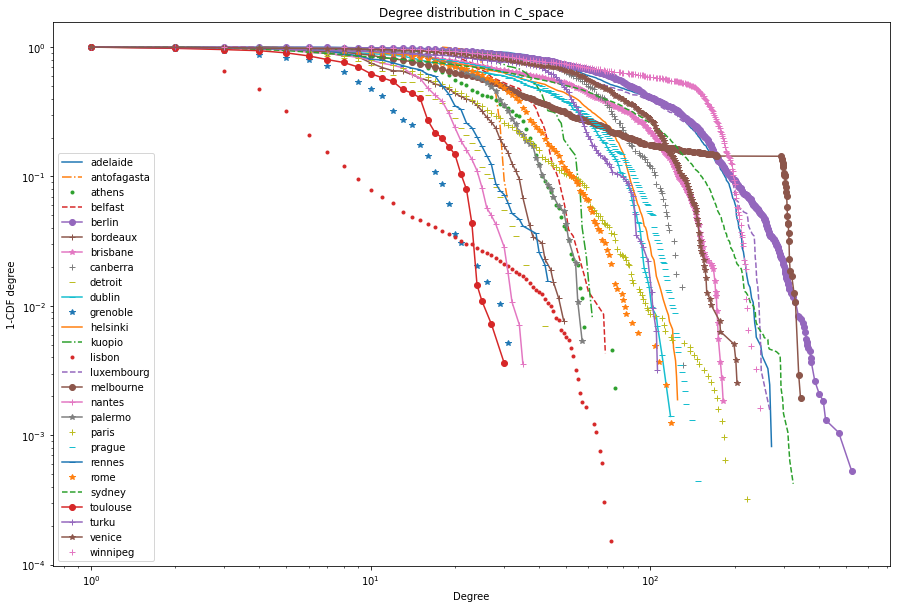

In [13]:
labels = cities
markers = [ '-', '-.','.', '--', '-o', '-+','-*','+','_','_-','*','-', '-.','.', '--', 
           '-o', '-+','-*','+','_','_-','*', '--', '-o', '-+','-*','+']
datavecs = [list(v) for v in cities_ccdf_degree.values()]
x = [list(v) for v in cities_degree.values()]
plot_ccdfs(x,datavecs, markers,labels);

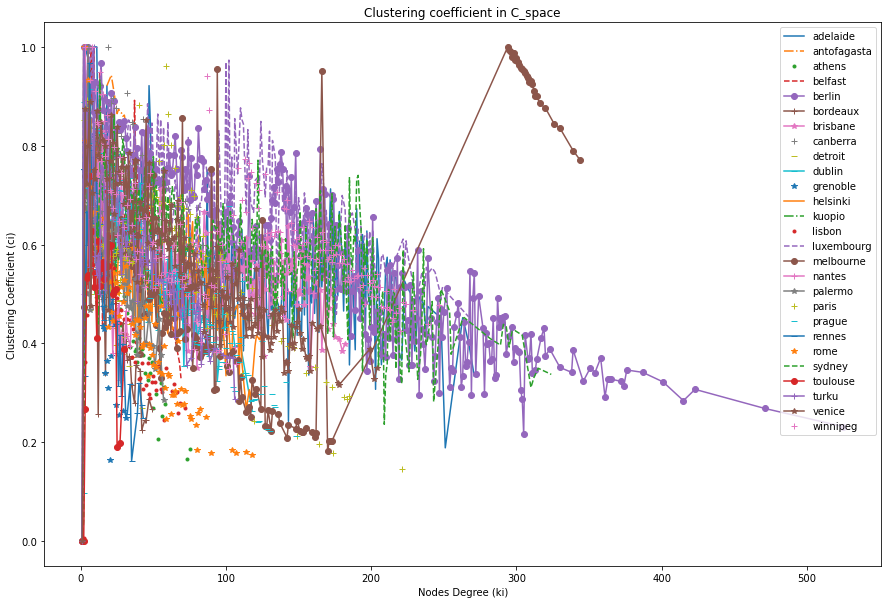

In [18]:
labels = cities
markers = [ '-', '-.','.', '--', '-o', '-+','-*','+','_','_-','*','-', '-.','.', '--', 
           '-o', '-+','-*','+','_','_-','*', '--', '-o', '-+','-*','+']
clusteringvec = [list(v) for v in cities_clustering.values()]
x = [list(v) for v in cities_total_degree.values()]
plot_degree_clustering(x,clusteringvec,markers, labels);

In [31]:
def get_centrality_measures(network):
    tol = 10**-1
    nodes = network.nodes()
    degrees = nx.degree_centrality(network)
    betweenness = nx.betweenness_centrality(network, normalized=True)
    closeness = nx.closeness_centrality(network)
    eigenvector_centrality = nx.eigenvector_centrality(network, tol = tol) 
   
    degree = np.array([v for k, v in  sorted(degrees.items(), key=lambda pair: list(nodes).index(pair[0]))])
    betweenness =np.array([v for k, v in  sorted(betweenness.items(), key=lambda  item: item[1], reverse = True)])
    closeness = np.array([v for k, v in  sorted(closeness.items(), key=lambda  item: item[1], reverse = True)])
    eigenvector_centrality = np.array([v for k, v in  sorted(eigenvector_centrality.items(),
                                                             key=lambda  item: item[1], reverse = True)])
    
    
    return [degree, betweenness, closeness, eigenvector_centrality]

In [32]:
def create_scatter(x_values, y_values, x_label, y_label, labels, markers):    
    fig = plt.figure()
    ax = fig.add_subplot(111)

    for y_val, label, marker in zip(y_values, labels, markers):
        ax.plot(x_values, y_val, ls='', marker=marker, label=label, alpha = 0.5)
        
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.grid()
    ax.legend(loc=0)

    return fig

In [33]:
x_label = 'Degree k'
y_label = 'Centrality measure'
labels = ['betweenness centrality', 'closeness centrality','eigenvector centrality']
markers = ['x', '+', 'o']
y_values = [betweenness, closeness, eigenvector_centrality]
degrees = [net.degree(node) for node in net.nodes()]
create_scatter(degrees, y_values, x_label, y_label, labels, markers);


NameError: name 'betweenness' is not defined